# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re

import umap.umap_ as umap

#from pandas_profiling import ProfileReport

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

from plotly import express as px

from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load dataset

In [4]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

In [5]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
128165,547250,22035,VINTAGE CARAVAN GREETING CARD,1,20-Mar-17,0.83,NaN,United Kingdom
254122,559295,22712,CARD DOLLY GIRL,12,5-Jul-17,0.42,12362.0,Belgium
272417,560772,22629,SPACEBOY LUNCH BOX,2,18-Jul-17,4.13,NaN,United Kingdom
179850,552290,22386,JUMBO BAG PINK POLKADOT,1,6-May-17,2.08,16007.0,United Kingdom
410882,572183,22866,HAND WARMER SCOTTY DOG DESIGN,12,19-Oct-17,2.10,16153.0,United Kingdom
301472,563288,22892,SET OF SALT AND PEPPER TOADSTOOLS,12,13-Aug-17,1.25,12656.0,France
342758,566913,21985,PACK OF 12 HEARTS DESIGN TISSUES,4,13-Sep-17,0.39,17602.0,United Kingdom
433948,574015,85045,GREEN CHRISTMAS TREE STRING 20LIGHT,2,31-Oct-17,4.95,15576.0,United Kingdom
444121,574720,22077,6 RIBBONS RUSTIC CHARM,3,4-Nov-17,1.95,14547.0,United Kingdom
390690,570594,23223,CHRISTMAS TREE HANGING SILVER,12,9-Oct-17,0.83,13517.0,United Kingdom


# Descrição dos dados

In [6]:
df1 = df_raw.copy()

## Rename Columns

In [7]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [8]:
df1.shape

(541909, 8)

## Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000+len(df_backup), 1)

#merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

#drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributs

In [17]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

#### Numerical Attributs - Investigating

1. quantidade negativa (pode ser devolução)
2. preço unitário igual a zero (pode ser promoção?)


### Categorical Attributs

#### Invoice No

In [18]:
#problema: temos letras no meio dos números

df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]', x))), :]

print('Total number of invoices: {}'.format( len (df_letter_invoice)))
print('Total de número negativos no quantity: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Total number of invoices: 9291
Total de número negativos no quantity: 9288


#### Stock Code

In [19]:
#check stock codes only caracters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
#delete description

#### Country

In [21]:
df1['country'].value_counts( normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [22]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# Filtragem de variáveis

In [23]:
df2 = df1.copy()

In [24]:
#===== Numerical Attribuets =====
#unit price > 0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code != [POST, D, M, DOT,CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#description
df2 = df2.drop( columns='description', axis=1)

#country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# Feature Engineering

In [25]:
df3 = df2.copy()

## Feature Creation

In [26]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country' ], axis=1).drop_duplicates(ignore_index=True)

### Gross Revenue
Faturamento

In [27]:
#Gross Revenue (Faturamento)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Recency Day
Último dia que foi feita uma compra

In [28]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### Quantity of  purchased
Quantas compras a pessoa fez

In [29]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### Quantity of items purchased
A quantidade de itens comprados

In [30]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### Quantity of products purchased

In [31]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename( columns={'stock_code': 'qtde_products'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### Average Ticket Value

In [32]:
#avg ticket (ticket médio)
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### Average Recency Days

In [33]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

#average recency
df_avg_recency_days = df_aux.groupby( 'customer_id').mean().reset_index()

#merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### Frequency Purchase

In [34]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                  .groupby( 'customer_id')
                                                  .agg( max_ = ( 'invoice_date', 'max'),
                                                        min_ = ( 'invoice_date', 'min'),
                                                        days_ = ('invoice_date', lambda x: (x.max() - x.min() ) .days),
                                                        buy_ = ('invoice_no', 'count') ) ).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### Number of Returns

In [35]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={ 'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### Basket Size
Quantidade de itens por cesta (quantity)

In [36]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'quantity', 'sum') ).reset_index())

#calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### Unique Basket Size
Quantidade de produtos distintos por compra

In [37]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'stock_code', 'count') ).reset_index())

#calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# EDA (Explory Data Analysis)

In [38]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Univariate Analysis
Investigar os outliers e tirar as sujeiros do datasets

In [39]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v1.html' )

Quanto maior o valor da kurtosis, maior a ponta do seu gráfico

Skewness - direita - positiva
         - esquerda- negativa

**Notes**
kurtosis - Quanto maior o valor, maior a ponta do seu gráfico

Skewness - direita - positiva - esquerda- negativa

1. Cluster Coesos - Separados
2. Métricas
    - min, max, range (dispersão)
    - média e mediana
    - desvio padrão e variância
    - coeficiente de variação (CV)
    - Distribuição

### Análise de outliers da variáveis

#### Gross Revenue

In [40]:
#os outliers presentes no gross revenue fazem sentido para o projeto de clusterização

#### Avg Ticket

In [41]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3338,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009756,80995.0,40498.5,1.5


In [42]:
df3[df3['customer_id'] == 16446]
#ele comprou 81 mil itens e devolveu todos eles, vale a pena manter esse customer no dataset?

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


## Bivariate Analysis
Verificar a variabilidade das variáveis para definir a variável resposta

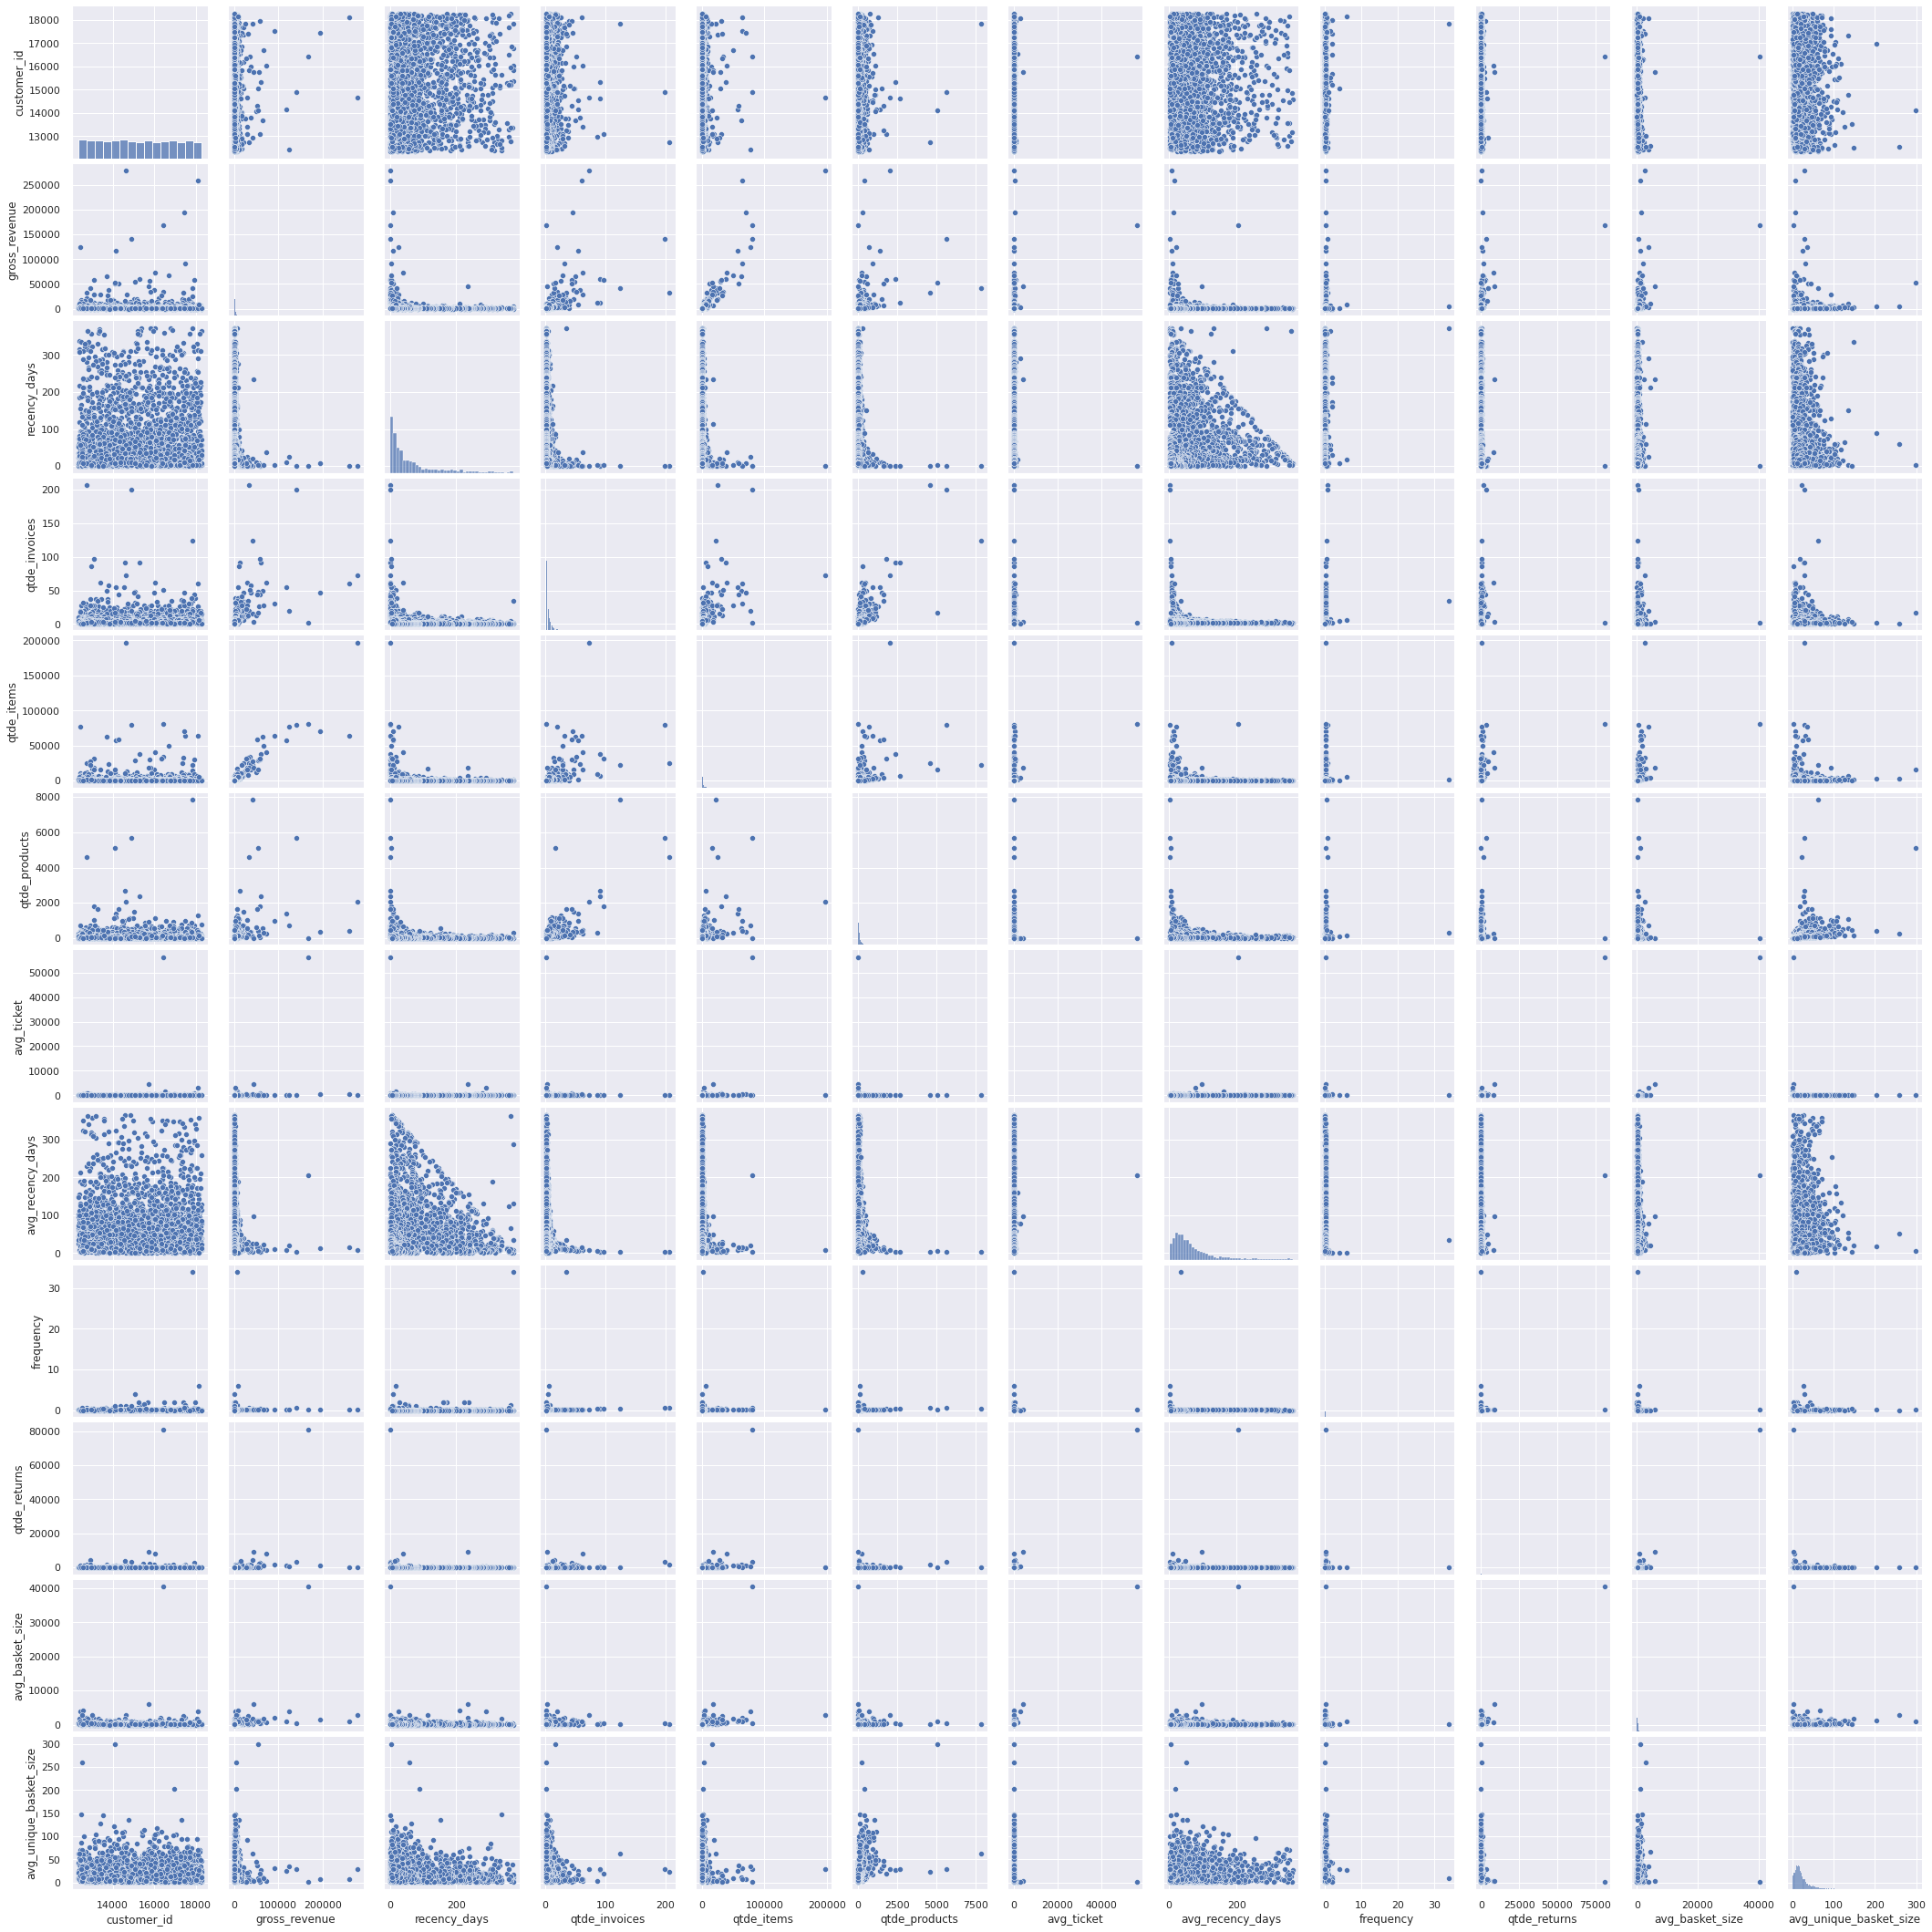

In [43]:
sns.pairplot(df4)

# Data Preparation

In [68]:
df5 = df4.copy()

In [97]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])

In [99]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


# Feature Selection

In [100]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [101]:
X = df6.drop(columns=['customer_id'])

In [102]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377193,2.791512,3.889210,-0.033939
1,0.135388,-0.361004,0.620928,-0.033427
2,0.524404,-0.899726,1.405316,-0.026622
3,-0.120499,0.028072,0.098003,-0.023244
4,-0.128592,2.402435,-0.163459,0.152443


##  Within-Cluster Sum of Square (Wss)

In [103]:
clusters = [2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'WSS vs K')

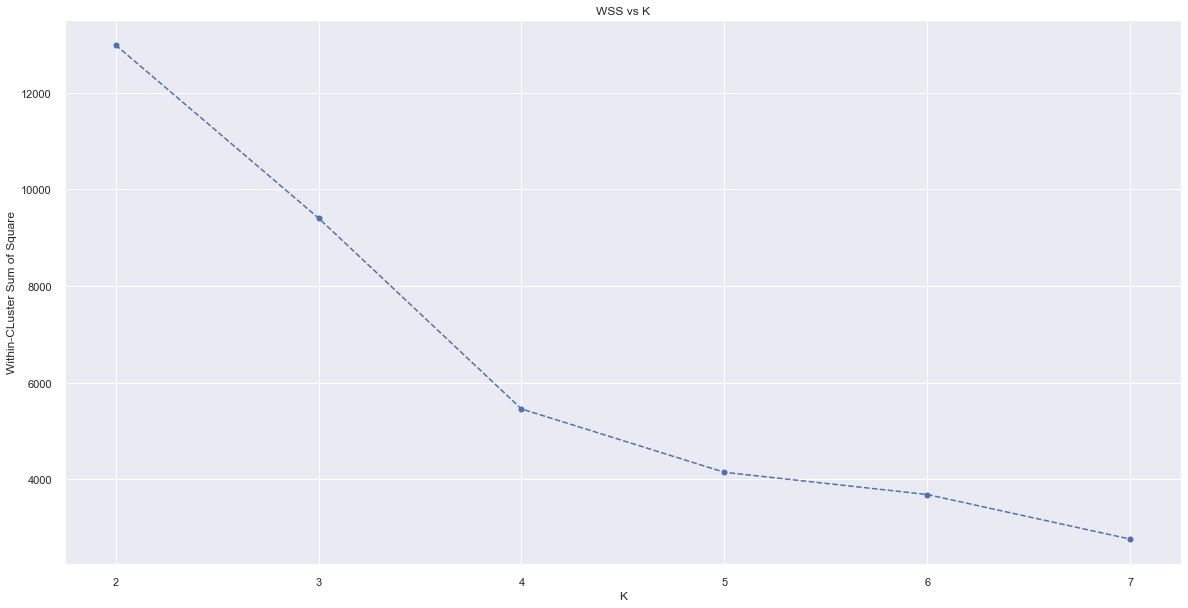

In [104]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

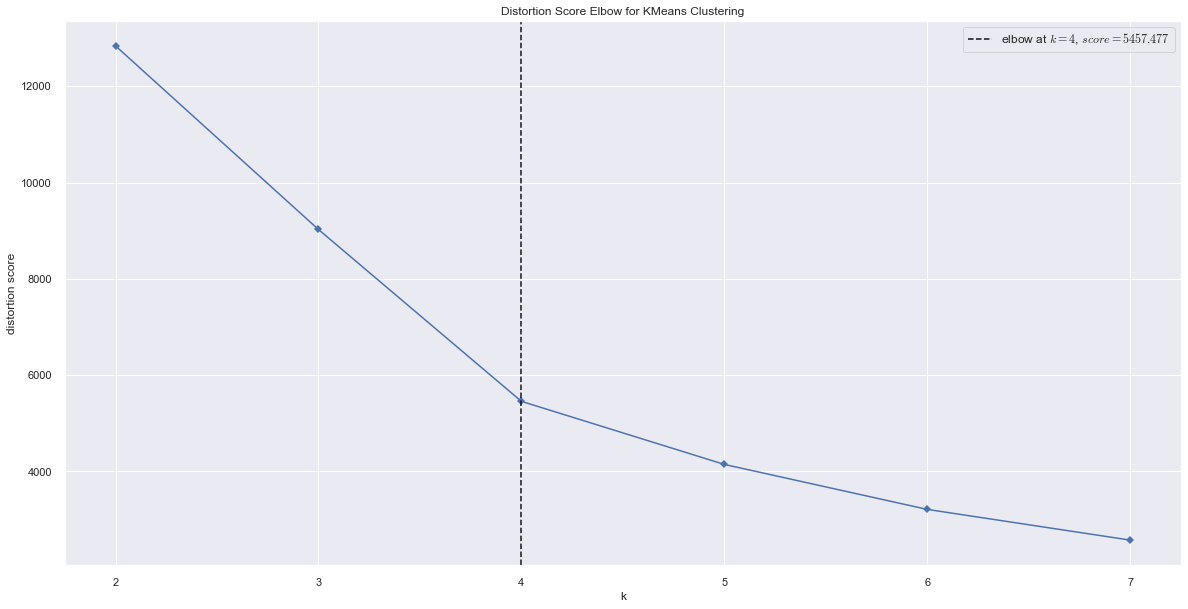

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [105]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show()

## Silhouette Score

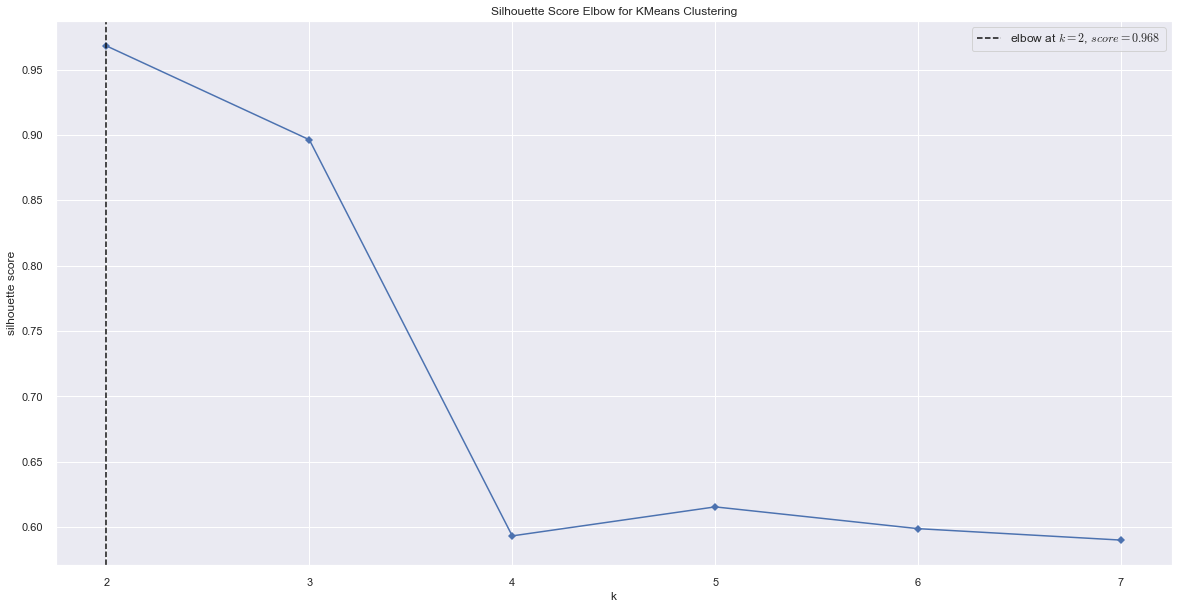

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [106]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show()

## Sillhouette Analysis

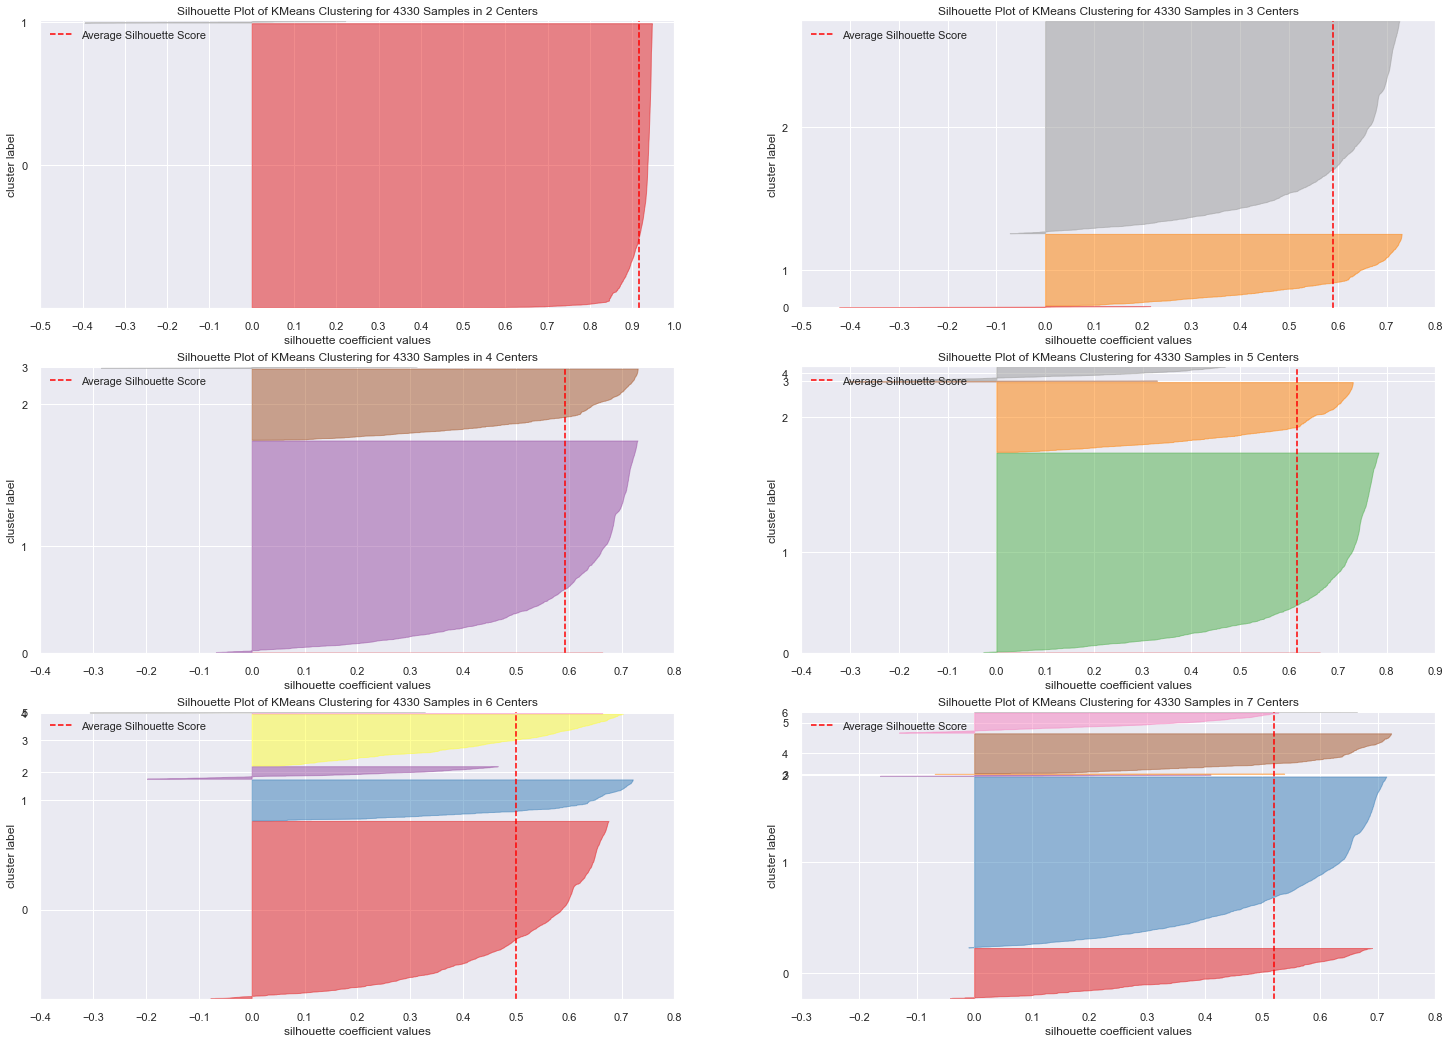

In [107]:
k=2

fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# Model Training

## K-Means

In [108]:
#model definition
k = 3
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## Cluster Validation

In [109]:
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 9404.957923270287
SS value: 0.5895242294229587


# Cluster Analysis

In [110]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


In [111]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,clusters
0,17850,0.377193,2.791512,3.889210,-0.033939,1
1,13047,0.135388,-0.361004,0.620928,-0.033427,0
2,12583,0.524404,-0.899726,1.405316,-0.026622,0
3,13748,-0.120499,0.028072,0.098003,-0.023244,0
4,15100,-0.128592,2.402435,-0.163459,0.152443,1


## Vizualization Inspection

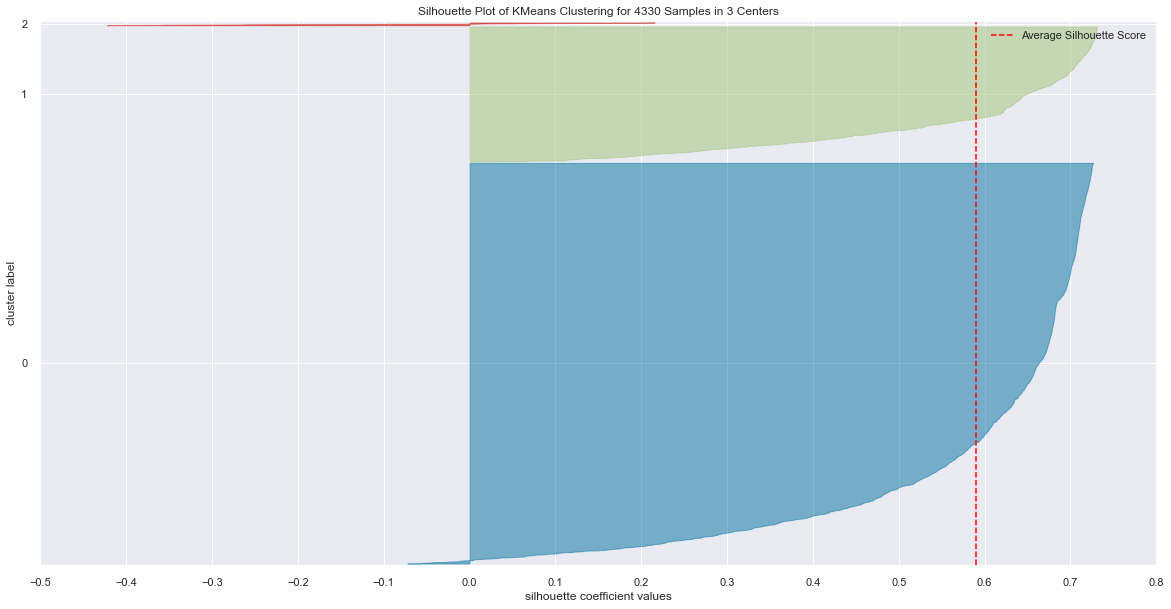

In [112]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

In [113]:
#f_viz = df9.drop( columns='customer_id', axis=1)
#ns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

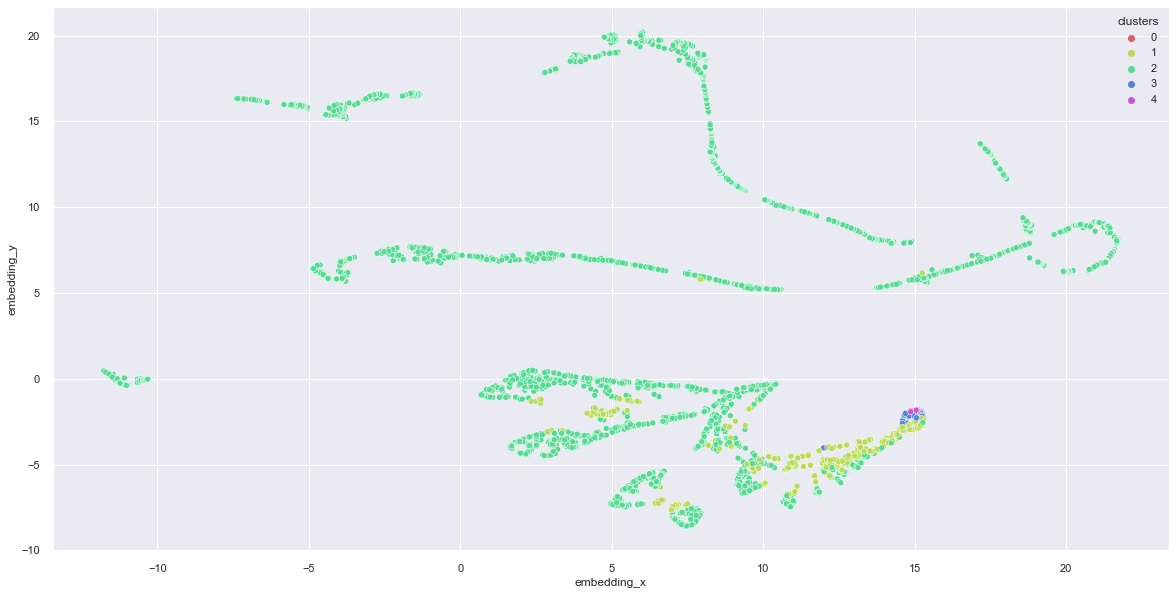

In [114]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [115]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
df_avg_invoice_no = df9[['invoice_no', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [68]:
df_cluster.head()
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,269,6.152790,8062.273755,20.282528,19.442379,62.479916
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,4069,93.069533,944.954398,97.006881,3.638978,25.361307
3,3,28,0.640439,42614.387143,6.178571,57.821429,162.862605


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares